# Final Project

Due: Fri 04/22/2022, 11:59pm

Group Name: Kaseri

# Importing Libraries

In [145]:
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
from keras import layers
from sklearn import metrics
from tensorflow import keras
from keras.layers import Dense
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import f1_score, accuracy_score, precision_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import recall_score, roc_auc_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

# Data Pre-Processing

In [146]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## Data description

In [147]:
df.shape

(5110, 12)

In [148]:
df.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [149]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [150]:
df.describe(include='object')

,gender,ever_married,work_type,Residence_type,smoking_status
count,5110,5110,5110,5110,5110
unique,3,2,5,2,4
top,Female,Yes,Private,Urban,never smoked
freq,2994,3353,2925,2596,1892


## Checking unique values

In [151]:
# checking unique values of each categorical column
col = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 
       'Residence_type', 'smoking_status', 'stroke']
for col in df[col]:
    print(df[col].unique())

['Male' 'Female' 'Other']
[0 1]
[1 0]
['Yes' 'No']
['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
['Urban' 'Rural']
['formerly smoked' 'never smoked' 'smokes' 'Unknown']
[1 0]


In [152]:
df.nunique()

id                   5110
gender                  3
age                   104
hypertension            2
heart_disease           2
ever_married            2
work_type               5
Residence_type          2
avg_glucose_level    3979
bmi                   418
smoking_status          4
stroke                  2
dtype: int64

In [153]:
# gender have three unique values. Checking the unique value count.
df['gender'].value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [154]:
# dropping the observation haing value as other in gender variable
df.drop(df.index[df['gender'] == 'Other'], inplace=True)

In [155]:
# dropping id column as it is not required (all observations are unique)
df.drop('id', axis=1, inplace=True)

## Duplicate Rows

In [156]:
# Duplicate Rows
duplicate = df[df.duplicated()]
print("Duplicate Rows :", df.duplicated().sum())

# non-duplicate rows
print("Non-Duplicate Rows :", (~df.duplicated()).sum())

Duplicate Rows : 0
Non-Duplicate Rows : 5109


## Handling null values

In [157]:
# checking null values
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [158]:
# Variable name with percent of missing data
missing_df = pd.DataFrame({'variable_name': df.columns,
                                 'percent_missing': (df.isnull().sum()*100 
                                                     / len(df)).round(4)})
missing_df[missing_df.percent_missing > 0].reset_index(drop=True)

,variable_name,percent_missing
0,bmi,3.9342


In [159]:
# imputing the null values

from sklearn.impute import SimpleImputer

imputeFit = SimpleImputer(missing_values=np.nan, strategy='mean')
imputeFit.fit(df.iloc[:, 8:9])
df.iloc[:, 8:9] = imputeFit.transform(df.iloc[:, 8:9])

In [160]:
# five number summary
df[['age', 'avg_glucose_level', 'bmi']].describe().loc[['min','25%','50%','75%',
                                                   'max']]

,age,avg_glucose_level,bmi
min,0.08,55.12,10.3
25%,25.00,77.24,23.8
50%,45.00,91.88,28.4
75%,61.00,114.09,32.8
max,82.00,271.74,97.6


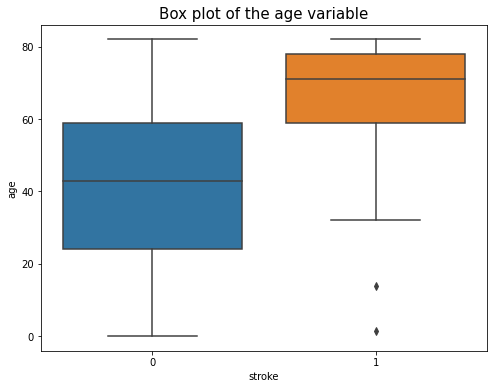

In [161]:
import seaborn as sns
f, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x='stroke', y="age", data=df)
plt.title('Box plot of the age variable', size=15)
plt.show()

In [162]:
df[df['age']==df['age'].min()]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1614,Female,0.08,0,0,No,children,Urban,139.67,14.1,Unknown,0
3295,Male,0.08,0,0,No,children,Rural,70.33,16.9,Unknown,0


In [163]:
df[df['age']==df['age'].max()]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
23,Male,82.0,0,1,Yes,Private,Rural,208.30,32.50000,Unknown,1
32,Female,82.0,1,0,Yes,Self-employed,Urban,196.92,22.20000,never smoked,1
35,Female,82.0,1,1,No,Private,Rural,84.03,26.50000,formerly smoked,1
42,Male,82.0,0,1,Yes,Private,Urban,144.90,26.40000,smokes,1
56,Female,82.0,0,0,Yes,Private,Rural,59.32,33.20000,never smoked,1
128,Male,82.0,0,0,Yes,Govt_job,Urban,200.59,29.00000,formerly smoked,1
140,Male,82.0,0,1,Yes,Govt_job,Rural,103.68,25.00000,never smoked,1
187,Female,82.0,1,1,Yes,Govt_job,Urban,215.94,27.90000,formerly smoked,1
188,Male,82.0,0,0,Yes,Private,Rural,86.62,29.50000,formerly smoked,1
337,Female,82.0,0,1,No,Private,Urban,215.60,24.90000,never smoked,0


In [164]:
df[(df['age']<1) & (df['gender']=='Male')].head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
982,Male,0.88,0,0,No,children,Rural,157.57,19.2,Unknown,0
996,Male,0.24,0,0,No,children,Rural,118.87,16.3,Unknown,0
1317,Male,0.80,0,0,No,children,Rural,98.67,17.5,Unknown,0
1600,Male,0.40,0,0,No,children,Urban,109.56,14.3,Unknown,0
1975,Male,0.56,0,0,No,children,Rural,111.77,21.1,Unknown,0


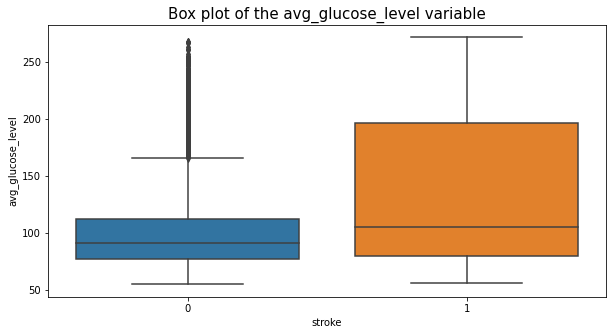

In [165]:
f, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(x='stroke', y="avg_glucose_level", data=df)
plt.title('Box plot of the avg_glucose_level variable', size=15)
plt.show()

In [166]:
#remove outliers
df['avg_glucose_level'].loc[(df['stroke']==0) & (df['avg_glucose_level']>165)]=165

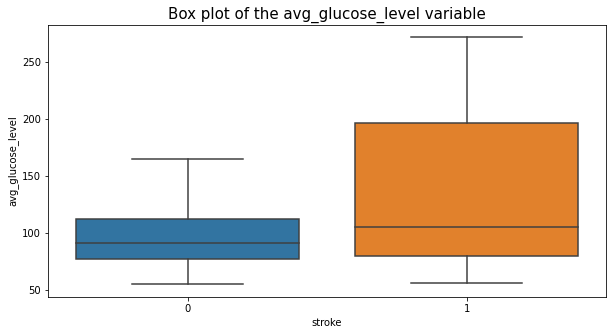

In [167]:
f, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(x='stroke', y="avg_glucose_level", data=df)
plt.title('Box plot of the avg_glucose_level variable', size=15)
plt.show()

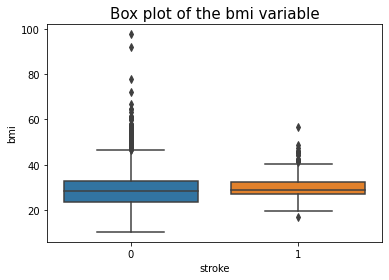

In [168]:
sns.boxplot(x='stroke', y="bmi", data=df)
plt.title('Box plot of the bmi variable', size=15)
plt.show()

In [169]:
df[df['bmi']==df['bmi'].max()]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
2128,Male,17.0,1,0,No,Private,Rural,61.67,97.6,Unknown,0


In [170]:
#remove outliers
df['bmi'].loc[(df['stroke']==0) & (df['bmi']>45)]=45

In [171]:
df['bmi'].loc[(df['stroke']==1) & (df['bmi']>40)]=40

In [172]:
df['bmi'].loc[(df['stroke']==1) & (df['bmi']<20)]=20

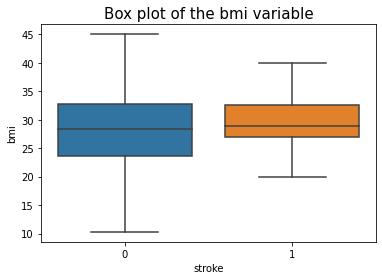

In [173]:
sns.boxplot(x='stroke', y="bmi", data=df)
plt.title('Box plot of the bmi variable', size=15)
plt.show()

The variables age and avg_glucose_level have outliers and transformation is required (center and scale).

## EDA

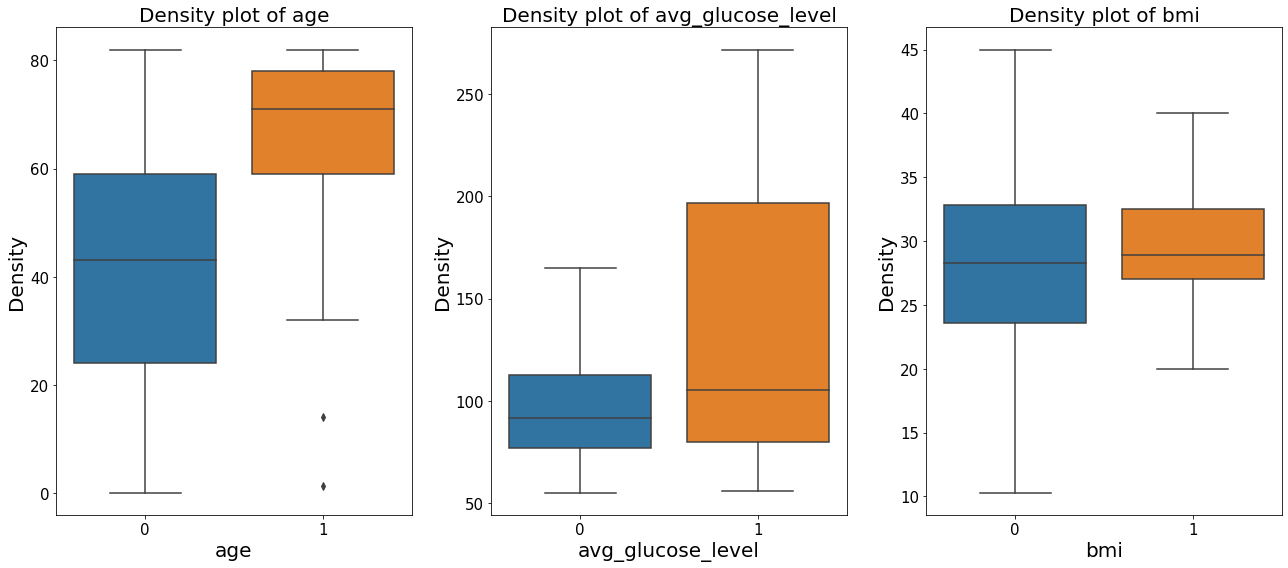

In [174]:
# density plot of numerical attributes
num_col = ['age', 'avg_glucose_level', 'bmi']
plt.figure(figsize=(18,8))
for i in enumerate(num_col):
    plt.subplot(1,3,i[0]+1)
    sns.boxplot(x='stroke', y=i[1], data=df)
    plt.xlabel(i[1],fontsize=20)
    plt.ylabel('Density',fontsize=20)
    plt.title('Density plot of '+ i[1], size=12,fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)




plt.tight_layout()
plt.show()

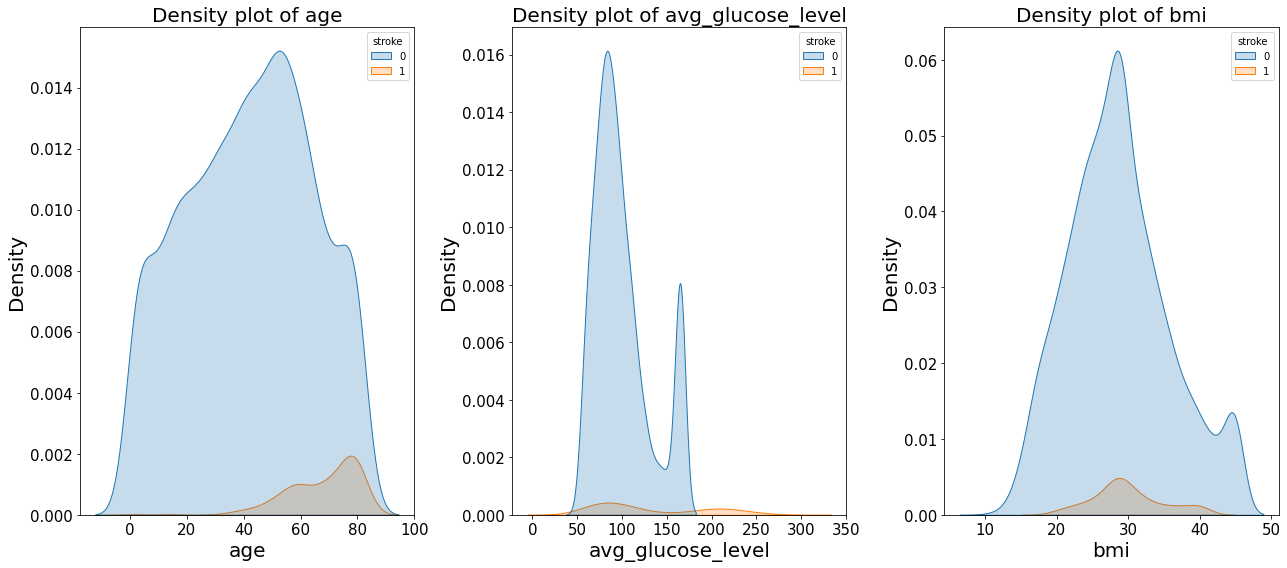

In [175]:
# density plot of numerical attributes
num_col = ['age', 'avg_glucose_level', 'bmi']
plt.figure(figsize=(18,8))
for i in enumerate(num_col):
    plt.subplot(1,3,i[0]+1)
    sns.kdeplot(x=i[1], data=df, hue='stroke',shade=True)
    plt.xlabel(i[1],fontsize=20)
    plt.ylabel('Density',fontsize=20)
    plt.title('Density plot of '+ i[1], size=12,fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)




plt.tight_layout()
plt.show()

The attributes avg_glucose_level and bmi are bit right skewed.

In [176]:
df['stroke'].value_counts()

0    4860
1     249
Name: stroke, dtype: int64

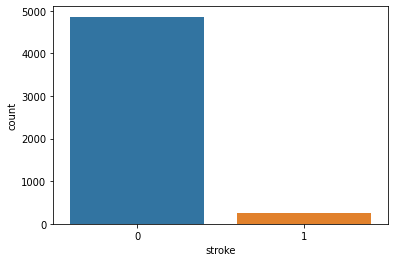

In [177]:
sns.countplot(x='stroke', data=df)

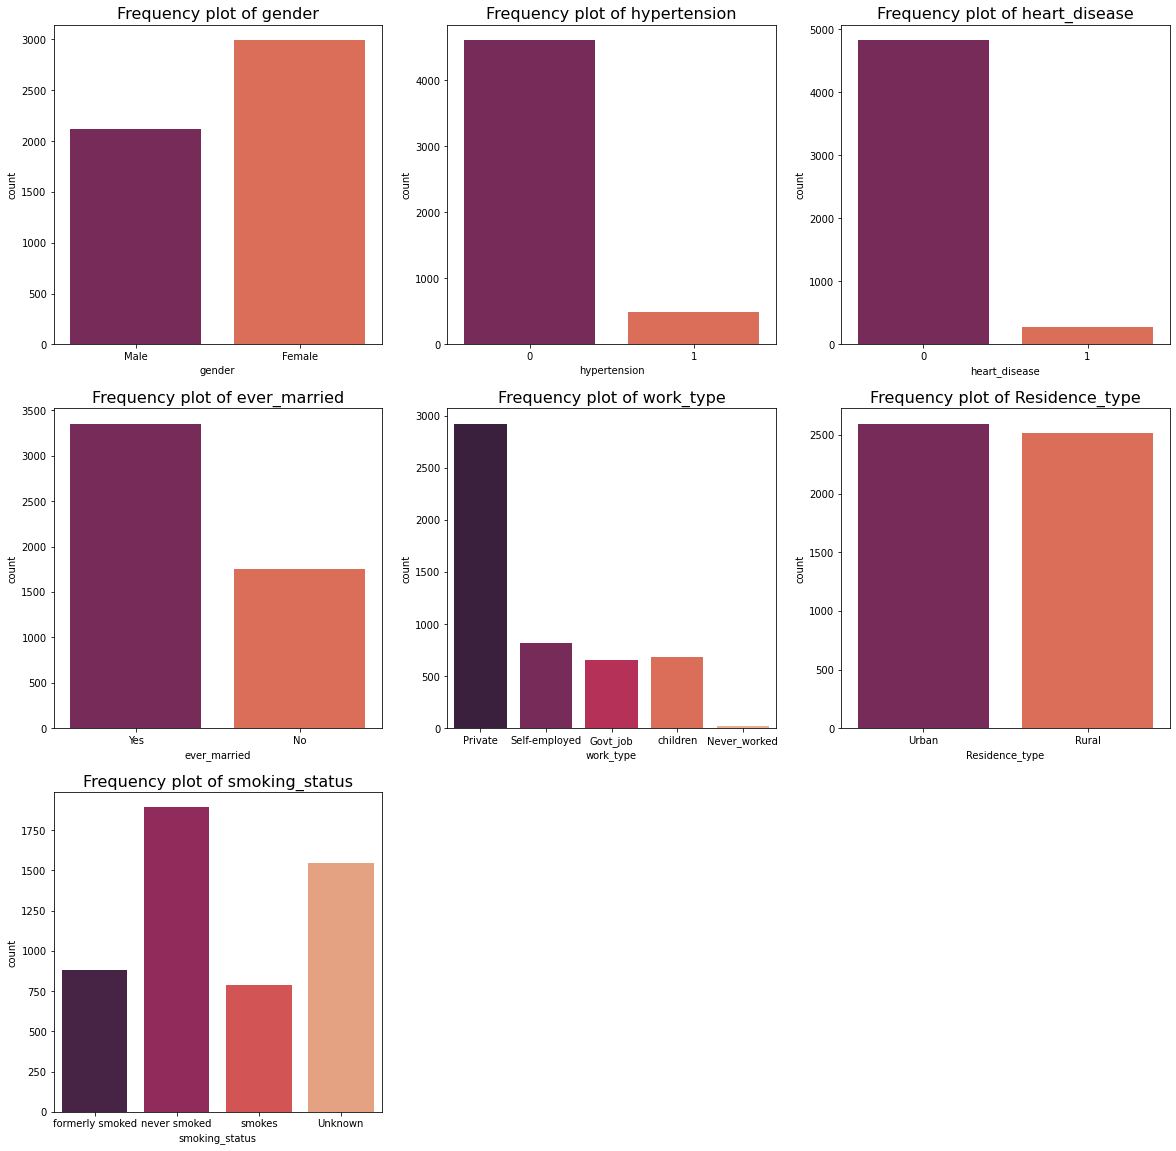

In [178]:
# frequency (bar) plot of categorical attributes
cat_col = ['gender', 'hypertension', 'heart_disease', 'ever_married', 
           'work_type', 'Residence_type', 'smoking_status']
plt.figure(figsize=(20,20))
sns.color_palette("husl", 8)
for i in enumerate(cat_col):
  plt.subplot(3,3,i[0]+1)
  sns.countplot(x=i[1], data=df, palette="rocket")
  plt.title('Frequency plot of '+ i[1], size=16)

plt.show()

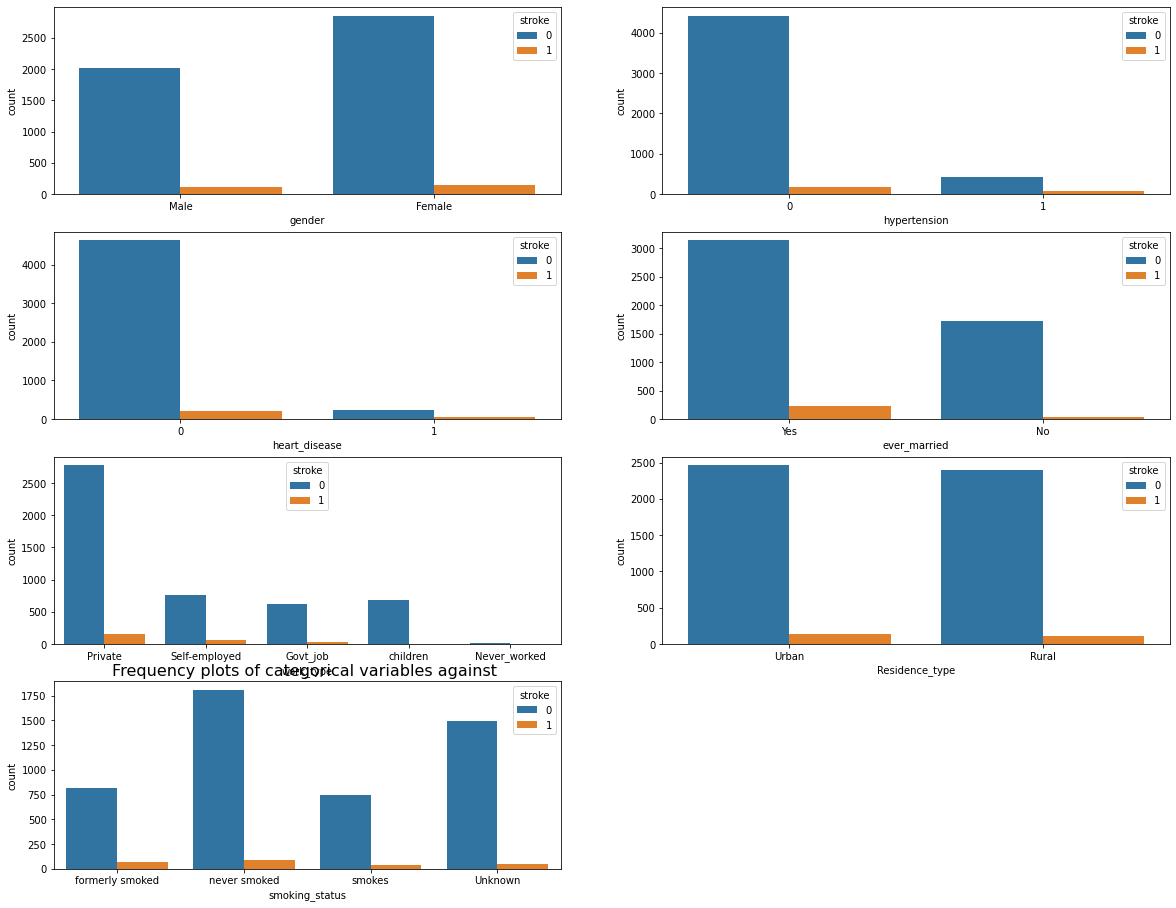

In [179]:
# frequency (bar) plot of categorical attributes with hue as stroke
plt.figure(figsize=(20,20))
for i in enumerate(cat_col):
  plt.subplot(5,2,i[0]+1)
  sns.countplot(x=i[1], data=df, hue='stroke')

plt.title('Frequency plots of categorical variables against ', size=16)
plt.show()

The target attribute (stroke) is imbalanced. Resampling is required for the dataset.

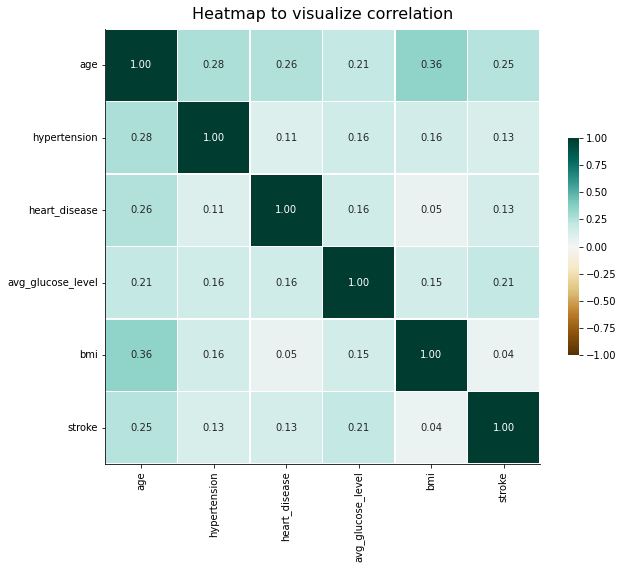

In [180]:
# checking correlation among the attributes using heatmap
g = sns.heatmap(df.corr(),  vmin=-1, vmax=1, center=0, square=True, 
                linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', 
                cmap='BrBG')

g.set_title('Heatmap to visualize correlation', fontdict={'fontsize':16}, 
            pad=10)

sns.despine()
g.figure.set_size_inches(10,8)   
plt.show()

As compared to other attributes Age and BMI have the higher correlation 0.33. All attributes are correlated to each other.

# Encoding the categorical variables

In [181]:
#encoding categorical columns to numerical with LabeEncoder
objects = df.select_dtypes(include = "object").columns
encoder = LabelEncoder()
for col in objects:
    df[col] = encoder.fit_transform(df[col].astype(str))
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,2,1,228.69,36.60000,1,1
1,0,61.0,0,0,1,3,0,202.21,28.89456,2,1
2,1,80.0,0,1,1,2,0,105.92,32.50000,2,1
3,0,49.0,0,0,1,2,1,171.23,34.40000,3,1
4,0,79.0,1,0,1,3,0,174.12,24.00000,2,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,0,80.0,1,0,1,2,1,83.75,28.89456,2,0
5106,0,81.0,0,0,1,3,1,125.20,40.00000,2,0
5107,0,35.0,0,0,1,3,0,82.99,30.60000,2,0
5108,1,51.0,0,0,1,2,0,165.00,25.60000,1,0


# Splitting the data

In [182]:
#creating predictor and response variable
X = df.iloc[:, 0:10]
y = df["stroke"]

#splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30,
                                                    stratify = y,
                                                    random_state = 5)

#Scaling the predictors

In [183]:
#scaling the continuous variables
cols_to_scale = ["age", "avg_glucose_level", "bmi"]
sc = StandardScaler()
X_train[cols_to_scale] = sc.fit_transform(X_train[cols_to_scale])
X_test[cols_to_scale] = sc.transform(X_test[cols_to_scale])

#Over-sampling the training data

In [184]:
smote = SMOTE(random_state=0)

X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

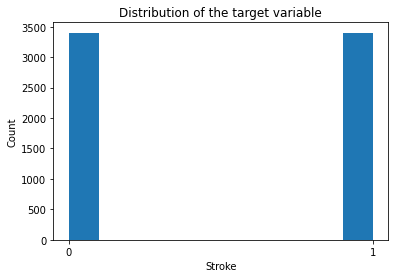

In [185]:
plt.hist(y_train_res)
plt.xlabel("Stroke")
plt.title("Distribution of the target variable")
plt.ylabel("Count")
plt.xticks(range(0, 2))
plt.show()

# Model building

## 1. **RandomForest**

In [186]:
param_grid = {'n_estimators': [35, 40, 45, 50]
             }

cv = StratifiedKFold(n_splits = 10, random_state=100, shuffle=True)

# Instantiate the grid-search
rf = GridSearchCV(RandomForestClassifier(random_state = 100), param_grid, 
                       scoring = "f1", cv=cv)

# run the grid search on training set
rf.fit(X_train_res, y_train_res)

rf_pred_train = rf.best_estimator_.predict(X_train_res)
rf_f1_pred =  metrics.f1_score(y_train_res, rf_pred_train)

rf_pred = rf.best_estimator_.predict(X_test)
rf_precision = metrics.precision_score(y_test, rf_pred, average='weighted')
rf_recall = metrics.recall_score(y_test, rf_pred, average='weighted')
rf_f1 =  metrics.f1_score(y_test, rf_pred, average='weighted')
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_best= "Estimators : %d" % (
    rf.best_params_['n_estimators'])
rf_auc = roc_auc_score(y_test, rf_pred, average='weighted')


cm = confusion_matrix(y_test, rf_pred)
cm

array([[1387,   71],
       [  36,   39]])

## 2. **KNN**

In [187]:
param_grid = {'n_neighbors': [3, 5, 7, 9, 11]}

cv = StratifiedKFold(n_splits=10, random_state=100, shuffle=True)

# Instantiate the grid-search
knn = GridSearchCV(KNeighborsClassifier(), param_grid, cv=cv, scoring = 'f1')

# run the grid search  
knn.fit(X_train_res, y_train_res)

knn_pred_train = knn.best_estimator_.predict(X_train_res)
knn_f1_pred =  metrics.f1_score(y_train_res, knn_pred_train)

knn_pred = knn.best_estimator_.predict(X_test)
knn_precision = metrics.precision_score(y_test, knn_pred, average='weighted')
knn_recall = metrics.recall_score(y_test, knn_pred, average='weighted')
knn_f1 =  f1_score(y_test, knn_pred, average='weighted')
knn_accuracy = accuracy_score(y_test, knn_pred)
knn_best = "Neighbours : %s" %(knn.best_params_['n_neighbors'])
knn_auc = roc_auc_score(y_test, knn_pred, average='weighted')

cm = confusion_matrix(y_test, knn_pred)
cm

array([[1266,  192],
       [  33,   42]])

## 3. **DecisionTree**

In [188]:
param_grid = {'max_depth': [25, 30, 35, 40, 45]}

cv = StratifiedKFold(n_splits=10, random_state=100, shuffle=True)

# Instantiate the grid-search
dt = GridSearchCV(DecisionTreeClassifier(random_state = 100), param_grid, cv=cv, scoring = 'f1')

# run the grid search 
dt.fit(X_train_res, y_train_res)

dt_pred_train = dt.best_estimator_.predict(X_train_res)
dt_f1_pred =  metrics.f1_score(y_train_res, dt_pred_train)

dt_pred = dt.best_estimator_.predict(X_test)
dt_precision = metrics.precision_score(y_test, dt_pred, average='weighted')
dt_recall = metrics.recall_score(y_test, dt_pred,average='weighted')
dt_f1 =  f1_score(y_test, dt_pred, average='weighted')
dt_accuracy = accuracy_score(y_test, dt_pred)
dt_best= "Max_Depth : %s" % (dt.best_params_['max_depth'])
dt_auc = roc_auc_score(y_test, dt_pred, average='weighted')

cm = confusion_matrix(y_test, dt_pred)
cm

array([[1342,  116],
       [  34,   41]])

## 4. **SVM**

In [189]:
# SVM

param_grid = {'C': [2, 4, 8, 16, 32, 64],
              'kernel': ['poly', 'rbf'],
              'degree': [6, 7, 8]
             }

cv = StratifiedKFold(n_splits=10, random_state=100, shuffle=True)

# Instantiate the grid-search
svm = GridSearchCV(SVC(random_state=100), param_grid, cv=cv, scoring = 'f1')

# run the grid search 
svm.fit(X_train_res, y_train_res)

svm_pred_train = svm.best_estimator_.predict(X_train_res)
svm_f1_pred =  metrics.f1_score(y_train_res, svm_pred_train)

svm_pred = svm.best_estimator_.predict(X_test)
svm_precision = metrics.precision_score(y_test, svm_pred, average='weighted')
svm_recall = metrics.recall_score(y_test, svm_pred, average='weighted')
svm_f1 =  f1_score(y_test, svm_pred, average='weighted')
svm_accuracy = accuracy_score(y_test, svm_pred)
svm_best= "C : %f, kernel %s, degree %d" % (
    svm.best_params_['C'], 
    svm.best_params_['kernel'],
    svm.best_params_['degree'])
svm_auc = roc_auc_score(y_test, svm_pred, average='weighted')

cm = confusion_matrix(y_test, svm_pred)
cm

array([[1284,  174],
       [  36,   39]])

## 5. **XGBClassifier**

In [190]:
# XGBClassifier

param_grid = {'max_depth': [13, 15, 17, 19, 21]}

cv = StratifiedKFold(n_splits=10, random_state=100, shuffle=True)

# Instantiate the grid-search
xgb = GridSearchCV(XGBClassifier(random_state=100), param_grid, cv=cv, scoring = 'f1')

# run the grid search 
xgb.fit(X_train_res, y_train_res)


xgb_pred_train = xgb.best_estimator_.predict(X_train_res)
xgb_f1_pred =  metrics.f1_score(y_train_res, xgb_pred_train)

xgb_pred = xgb.best_estimator_.predict(X_test)
xgb_precision = metrics.precision_score(y_test, xgb_pred, average='weighted')
xgb_recall = metrics.recall_score(y_test, xgb_pred, average='weighted')
xgb_f1 =  f1_score(y_test, xgb_pred, average='weighted')
xgb_accuracy = accuracy_score(y_test, xgb_pred)
xgb_best= "Max_depth : %s" % (xgb.best_params_['max_depth'])
xgb_auc = roc_auc_score(y_test, xgb_pred, average='weighted')
cm = confusion_matrix(y_test, xgb_pred)
cm

array([[1389,   69],
       [  40,   35]])

In [191]:
#reporting the results of the test set in a table
df = pd.DataFrame({'Claasifier':["KNN", "Decision Tree", "SVM", "Random Forest", "XG Boost"],
                 'Best Parameters': [knn_best, dt_best, svm_best, rf_best, xgb_best],
                 "Precison":[knn_precision, dt_precision, svm_precision, rf_precision, xgb_precision],
                 "Recall":[knn_recall, dt_recall, svm_recall, rf_recall, xgb_recall],
                 "F1-score":[knn_f1, dt_f1, svm_f1, rf_f1, xgb_f1],
                 "Accuracy":[knn_accuracy, dt_accuracy, svm_accuracy, rf_accuracy, xgb_accuracy],
                 "AUC":[knn_auc, dt_auc, svm_auc, rf_auc, xgb_auc]
                 })
df

,Claasifier,Best Parameters,Precison,Recall,F1-score,Accuracy,AUC
0,KNN,Neighbours : 3,0.935696,0.853229,0.886758,0.853229,0.714156
1,Decision Tree,Max_Depth : 25,0.940352,0.902153,0.918029,0.902153,0.733553
2,SVM,"C : 64.000000, kernel poly, degree 8",0.934096,0.863014,0.892431,0.863014,0.700329
3,Random Forest,Estimators : 45,0.944361,0.930202,0.936381,0.930202,0.735652
4,XG Boost,Max_depth : 21,0.940919,0.928898,0.934300,0.928898,0.709671


In [193]:
#storing testing set results of best model to a csv file
#best model = Random Forest 
from google.colab import files
rf_df = pd.DataFrame(columns = ["Observed", "Predicted"])

observed = y_test 
predicted = rf_pred

rf_df["Observed"] =  observed
rf_df["Predicted"] = predicted
rf_df.reset_index().drop("index", axis = 1).to_csv("output.csv")
files.download('output.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>